## References
https://www.medi-08-data-06.work/entry/regression_stan<br>
http://techtipshoge.blogspot.com/2017/04/pystan1.html<br>
https://dev.classmethod.jp/statistics/pystan-gauss-linear-regression/

In [3]:
!pip install statsmodels

  Using cached patsy-0.5.1-py2.py3-none-any.whl (231 kB)


In [57]:
import numpy as np
import numpy.random as rd
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation as ani
import matplotlib.cm as cm
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)

#from tabulate import tabulate
from time import time

import pystan
from pystan import StanModel

import statsmodels.api as sm
import statsmodels.formula.api as smf

### data

In [5]:
data = pd.read_csv("./data.csv")
col_name = data.columns
data

,Region,Type,1st Size,2nd Size,1st mean,2nd mean,1st std,2nd std
0,A,1,55,51,151.36,157.27,2.94,2.98
1,B,1,53,49,151.56,156.83,3.07,3.14
2,C,0,55,53,152.22,157.08,3.20,3.21
3,D,1,53,52,153.09,156.00,2.65,2.64
4,E,1,58,55,153.22,157.24,3.07,3.03
5,F,0,55,53,153.31,157.22,3.10,3.13
6,G,0,58,53,152.98,157.81,2.49,2.45
7,H,0,59,57,153.27,158.95,3.08,3.06
8,I,1,56,51,152.67,156.82,2.82,2.92
9,J,0,56,50,155.37,161.71,3.10,3.21


In [6]:
# data preparation
Y = np.hstack([data["1st mean"], data["2nd mean"]])
Age = np.hstack([np.zeros(10), np.ones(10)])
X = np.hstack([data["Type"], data["Type"]])
X = np.hstack([X.reshape(-1,1), Age.reshape(-1,1)])
X = pd.DataFrame(X)

### model1

In [7]:
# data preparationfor model1
data_model1 = pd.concat([X,pd.DataFrame(Y)], axis=1)
data_model1.columns = ["Type", "Age", "meanY"]
data_model1

,Type,Age,meanY
0,1.0,0.0,151.36
1,1.0,0.0,151.56
2,0.0,0.0,152.22
3,1.0,0.0,153.09
4,1.0,0.0,153.22
5,0.0,0.0,153.31
6,0.0,0.0,152.98
7,0.0,0.0,153.27
8,1.0,0.0,152.67
9,0.0,0.0,155.37


In [8]:
formula = "meanY ~  1 + Age + Age:Type"
link = sm.genmod.families.links.identity
family = sm.families.Gaussian(link=link)

mod = smf.glm(formula=formula, data=data_model1, family=family )
result = mod.fit() 
print(result.summary())

print(result.aic)

C:\Users\yoshi\Miniconda3\envs\stan\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  This is separate from the ipykernel package so we can avoid doing imports until


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  meanY   No. Observations:                   20
Model:                            GLM   Df Residuals:                       17
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                          1.5827
Method:                          IRLS   Log-Likelihood:                -31.345
Date:                Sun, 28 Jun 2020   Deviance:                       26.907
Time:                        17:50:34   Pearson chi2:                     26.9
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    152.9050      0.398    384.341      0.0

### Bayes model1

In [9]:
data_model1.iloc[:,:2]

,Type,Age
0,1.0,0.0
1,1.0,0.0
2,0.0,0.0
3,1.0,0.0
4,1.0,0.0
5,0.0,0.0
6,0.0,0.0
7,0.0,0.0
8,1.0,0.0
9,0.0,0.0


In [10]:
X = data_model1.iloc[:,:2]
y = data_model1.iloc[:,-1]

In [11]:
dat = {'N': X.shape[0], 'M': X.shape[1], 'X': X, 'y': y}

In [12]:
stan_model = """
data {
    int<lower=0> N;
    int<lower=0> M;
    matrix[N,M] X;
    real y[N];
}

parameters {
    real beta1;
    real beta2;
    real beta3;
    real<lower=0> sigma;
}

model{
    for (n in 1:N){
      y[n] ~ normal(beta1 + beta2 * X[n,2] + beta3*X[n,1]*X[n,2], sigma);
    }
    beta1 ~ uniform(-1e+4, 1e+4);
    beta2 ~ uniform(-1e+4, 1e+4);
    beta3 ~ uniform(-1e+4, 1e+4);
    sigma ~ uniform(-1e+4, 1e+4);
}
 
"""

In [13]:
# Build Stan model
%time stm = StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_433ba1d713981081b1bc4b0f8c03d857 NOW.


Wall time: 54.2 s


In [14]:
n_itr = 3000
n_warmup = 200
chains = 2

# サンプリングの実行
fit = stm.sampling(data=dat, iter=n_itr, chains=chains, n_jobs=-1, warmup=n_warmup, algorithm="NUTS", verbose=False)
la    = fit.extract(permuted=True)  # return a dictionary of arrays
# パラメーター名
names = fit.model_pars 
# パラメーターの数
n_param = np.sum([1 if len(x) == 0 else x[0] for x in fit.par_dims])
print(fit)

Inference for Stan model: anon_model_433ba1d713981081b1bc4b0f8c03d857.
2 chains, each with iter=3000; warmup=200; thin=1; 
post-warmup draws per chain=2800, total post-warmup draws=5600.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta1  152.9  7.9e-3   0.44 152.03 152.62 152.89 153.17 153.77   3119    1.0
beta2   5.66    0.02   0.78   4.11   5.18   5.66   6.16   7.17   2484    1.0
beta3  -1.72    0.02    0.9  -3.47  -2.31  -1.72  -1.13   0.09   2589    1.0
sigma   1.37  4.8e-3   0.27   0.97   1.18   1.33   1.51   1.98   3165    1.0
lp__   -15.1    0.04   1.68 -19.44 -15.86 -14.71 -13.91 -13.07   1801    1.0

Samples were drawn using NUTS at Sun Jun 28 17:51:31 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


### model 2

In [44]:
y = np.vstack([data["1st mean"], data["2nd mean"]])
X = np.vstack([data["Type"], data["Type"]])
Age = np.vstack([np.zeros(10),np.ones(10)])
dat = {'T': X.shape[0], 'P':X.shape[1], 'Age':Age, 'X': X, 'y': y}

In [38]:
stan_model2 = """
data {
    int<lower=0> T;
    int<lower=0> P;
    matrix[T,P] X;
    matrix[T,P] Age;
    matrix[T,P] y;
}

parameters {
    real beta1;
    real beta2;
    real beta3;
    real<lower=0> sigma;
    vector[T] s;
    matrix[T,P] r;
}

transformed parameters {
    matrix[T,P] mu;
    for (i in 1:T){
        for (j in 1:P){
            mu[i,j] = beta1 + r[1,j] + (beta2 + beta3*X[i,j] + r[2,j])*Age[i,j];
        }
    }
}

model {
    for (i in 1:T){
        s[i] ~ uniform(0, 1e+4);
        for (j in 1:P){
             y[i,j] ~ normal(mu[i,j], sigma);
             r[i,j] ~ normal(0,s[i]);
             }
     }
    
    beta1 ~ uniform(-1e+4, 1e+4);
    beta2 ~ uniform(-1e+4, 1e+4);
    beta3 ~ uniform(-1e+4, 1e+4);
    sigma ~ uniform(-1e+4, 1e+4);
}
 
"""

In [39]:
# Build Stan model
%time stm = StanModel(model_code=stan_model2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a13e08b708967d6c678dedda748fe271 NOW.


Wall time: 37.5 s


In [45]:
n_itr = 3000
n_warmup = 200
chains = 2

# サンプリングの実行
fit = stm.sampling(data=dat, iter=n_itr, chains=chains, n_jobs=-1, warmup=n_warmup, algorithm="NUTS", verbose=False)
la    = fit.extract(permuted=True)  # return a dictionary of arrays
# パラメーター名
names = fit.model_pars 
# パラメーターの数
n_param = np.sum([1 if len(x) == 0 else x[0] for x in fit.par_dims])
print(fit)

Inference for Stan model: anon_model_a13e08b708967d6c678dedda748fe271.
2 chains, each with iter=3000; warmup=200; thin=1; 
post-warmup draws per chain=2800, total post-warmup draws=5600.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta1     152.9    0.01   0.45 151.94 152.64  152.9 153.18 153.75   1030    1.0
beta2      5.29    0.02   0.64   4.07    4.9   5.27   5.65   6.65   1562    1.0
beta3     -0.98    0.03   0.91  -2.92  -1.55  -0.93  -0.42   0.77   1108    1.0
sigma      0.65    0.02   0.34   0.15   0.38   0.62   0.87   1.41    267    1.0
s[1]       1.12    0.02   0.47   0.32   0.82   1.07   1.36   2.16    629    1.0
s[2]       0.92    0.03   0.51   0.09   0.57   0.87    1.2   2.07    413    1.0
r[1,1]    -0.87    0.03   0.71  -2.19  -1.38  -0.87  -0.39    0.5    467    1.0
r[2,1]     0.65    0.03    0.8  -0.78   0.06   0.59   1.18    2.3    851    1.0
r[1,2]    -0.84    0.03   0.69  -2.12  -1.31  -0.86  -0.36   0.53    539    1.0
r[2,2]     0

### visualization

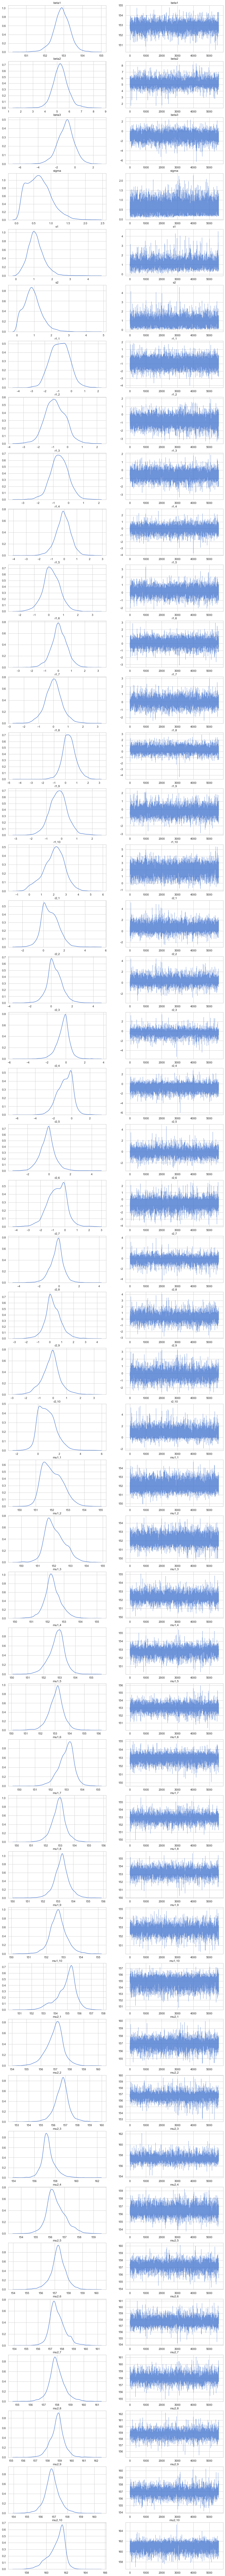

In [161]:
la  = fit.extract(permuted=True) #extract results
names = fit.model_pars #get  parameters names
n_param = np.sum([1 if len(x) == 0 else np.prod(x) for x in fit.par_dims])
f, axes = plt.subplots(n_param, 2, figsize=(15, 4*n_param))
cnt=0
for name in names:
    temp_data = la[name]
    #r, mu
    if temp_data.ndim == 3:
        for i in range(temp_data.shape[1]):
            for j in range(temp_data.shape[2]):
                d = temp_data[:,i,j]
                sns.distplot(d, hist=False, ax=axes[cnt, 0])
                x = np.linspace(0, len(d)-1, len(d))
                sns.lineplot(x,d,alpha=0.8, lw=.5, ax=axes[cnt, 1])
                cnt += 1
    #s
    elif temp_data.ndim == 2:
        for i in range(temp_data.shape[1]):
            d = temp_data[:,i]
            sns.distplot(d, hist=False, ax=axes[cnt, 0])
            x = np.linspace(0, len(d)-1, len(d))
            sns.lineplot(x,d,alpha=0.8, lw=.5, ax=axes[cnt, 1])
            cnt += 1
    #Intercept
    else:
        sns.distplot(temp_data, hist=False, ax=axes[cnt, 0])
        x = np.linspace(0, len(temp_data)-1, len(temp_data))
        sns.lineplot(x, temp_data,alpha=0.8, lw=.5, ax=axes[cnt, 1])
        cnt += 1
        
name_list = []
for name in names:
    temp_data = la[name]
    if temp_data.ndim == 3:
        for i in range(temp_data.shape[1]):
            for j in range(temp_data.shape[2]):
                name_list.append("{}{},{}".format(name,i+1,j+1))
    elif temp_data.ndim == 2:
        for i in range(temp_data.shape[1]):
            name_list.append("{}{}".format(name,i+1))
    else:
        name_list.append(name)

for i in range(2):
    for j, t in enumerate(name_list):
        axes[j, i].set_title(t)
plt.show()